In [1]:
# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

""

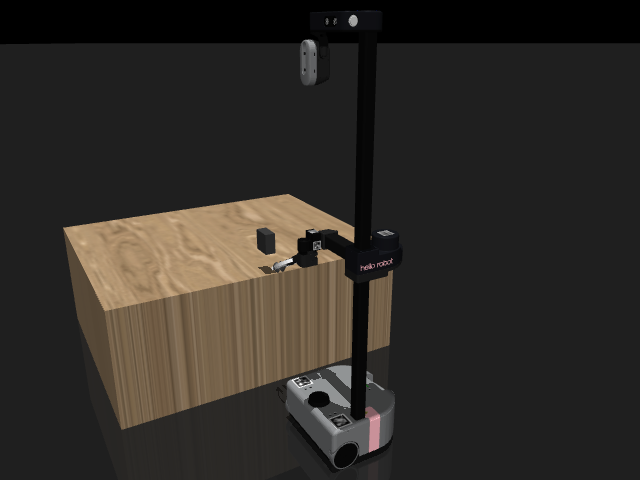

In [2]:
from pathlib import Path
import enum
from tqdm import tqdm

class Resolution(enum.Enum):
  SD = (480, 640)
  HD = (720, 1280)
  UHD = (2160, 3840)

res = Resolution.SD
h, w = res.value

model_dir = Path("mujoco_menagerie/hello_robot_stretch") # You could also use google_robot
model_xml = model_dir / "scene.xml"

# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

# Make sure offscreen rendering can support the desired resolution.
model.vis.global_.offheight = h
model.vis.global_.offwidth = w

renderer = mujoco.Renderer(model, height=h, width=w)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [3]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [4]:
print(data.body(8))

<_MjDataBodyViews
  cacc: array([0., 0., 0., 0., 0., 0.])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([0., 0., 0., 0., 0., 0.])
  cinert: array([ 0.014,  0.013,  0.004, -0.002,  0.004,  0.005,  0.015,  0.02 , -0.041,  0.15 ])
  crb: array([ 0.014,  0.013,  0.004, -0.002,  0.004,  0.005,  0.015,  0.02 , -0.041,  0.15 ])
  cvel: array([0., 0., 0., 0., 0., 0.])
  id: 8
  name: 'link_left_wheel'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([0.   , 0.158, 0.051])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([ 0.   , -0.447,  0.894,  1.   ,  0.   ,  0.   ,  0.   ,  0.894,  0.447])
  xipos: array([0.   , 0.158, 0.051])
  xmat: array([ 1., -0.,  0.,  0.,  0.,  1., -0., -1.,  0.])
  xpos: array([0.   , 0.17 , 0.051])
  xquat: array([ 0.707, -0.707,  0.   ,  0.   ])
>


In [8]:
model.body('link_left_wheel').ipos
# data.qpos

array([ 0.   ,  0.   , -0.013])

In [6]:
model.body(8).pos[1] * 2

np.float64(0.3407)

In [9]:
from algorithms import Odometry
from math import *

def set_wheel_speeds(left_speed, right_speed):
    data.joint('joint_left_wheel').qvel = np.array([left_speed])
    data.joint('joint_right_wheel').qvel = np.array([right_speed])
    
def update_position(left_speed, right_speed, dt, wheel_base, x, y, theta):
    v = (left_speed + right_speed) / 2.0
    omega = (right_speed - left_speed) / wheel_base
    x += v * cos(theta) * dt
    y += v * sin(theta) * dt
    theta += omega * dt

def distance_to_point(self, x_goal, y_goal, x, y):
    return sqrt((x_goal - x) ** 2 + (y_goal - y) ** 2)

def control_robot(x_goal, y_goal, x, y, v, omega, dt, threshold=0.1):
  while distance_to_point(x_goal, y_goal, x, y) > threshold:
      distance = distance_to_point(x_goal, y_goal, x, y)
      angle_to_goal = atan2(y_goal - y, x_goal - x)
      angle_diff = angle_to_goal - theta
      
      if angle_diff > pi:
          angle_diff -= 2 * pi
      elif angle_diff < -pi:
          angle_diff += 2 * pi
      
      v_left = v - omega * angle_diff
      v_right = v + omega * angle_diff
      
      set_wheel_speeds(v_left, v_right)
      update_position(v_left, v_right, dt)
      mujoco.mj_step(model, data)
      if len(frames) < data.time * 30:
          renderer.update_scene(data, camera, scene_option=vis)
          vispix = renderer.render().copy().astype(np.float32)
          frame = vispix.astype(np.uint8)
          frames.append(frame)
      # Render the frame
      # self.viewer.render()
      
  set_wheel_speeds(0, 0)
  print("Reached the goal and stopped.")
   

# odometry = Odometry(velocity = 1, breadth=model.body(8).pos[1] * 2)

vis = mujoco.MjvOption()
vis.geomgroup[2] = True
vis.geomgroup[3] = False
coll = mujoco.MjvOption()
coll.geomgroup[2] = False
coll.geomgroup[3] = True
coll.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 4

duration = 10
fps = 30
nsteps = int(np.ceil(duration / model.opt.timestep))

# Set the desired control point.
if model.nkey > 0:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  ctrl0 = data.ctrl.copy()
else:
  mujoco.mj_resetData(model, data)
  ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)

threshold = 0.1
# data.ctrl[0] = 1
# data.ctrl[1] = 1
# odometry.set_waypoint(1, 1)
# rv = odometry.wheel_vel_right
# rl = odometry.wheel_vel_left
# print(f'next pos:{odometry.next_pos}')
# print(odometry.radius, odometry.ang_vel, odometry.delta_angle, rv, rl)

frames = []

for i in tqdm(range(nsteps)):
  data.joint('joint_right_wheel').qvel = np.array([rv])
  data.joint('joint_left_wheel').qvel = np.array([rl])

  mujoco.mj_step(model, data)
  if len(frames) < data.time * fps:
    renderer.update_scene(data, camera, scene_option=vis)
    vispix = renderer.render().copy().astype(np.float32)
    frame = vispix.astype(np.uint8)
    frames.append(frame)

media.show_video(frames, fps=fps, loop=False)
# print(f'robot position: {data.body(1).xpos}')

next pos:[1.241 0.678 1.   ]


100%|██████████| 5000/5000 [00:02<00:00, 1882.47it/s]


In [8]:
# print(data.body(7))
# print(data.body(8)) # 7 - right, 8 - left
# odometry = Odometry(breadth=model.body(8).pos[1] * 2)
# print(odometry.breadth)